### Gradient Boosting implementaion from scratch

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [45]:
df = pd.read_csv('../../src/cleaned_data/cleaned_data.csv')

In [46]:
class SimpleDecisionTreeRegressor:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return np.mean(y)
        
        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return np.mean(y)
        
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return (best_feature, best_threshold, left_subtree, right_subtree)
    
    def _find_best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_y = y[X[:, feature] <= threshold]
                right_y = y[X[:, feature] > threshold]
                
                if len(left_y) == 0 or len(right_y) == 0:
                    continue
                
                mse = (np.var(left_y) * len(left_y) + np.var(right_y) * len(right_y)) / len(y)
                
                if mse < best_mse:
                    best_feature, best_threshold, best_mse = feature, threshold, mse
        
        return best_feature, best_threshold
    
    def predict(self, X):
        return np.array([self._predict_single(x, self.tree) for x in X])
    
    def _predict_single(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, threshold, left_subtree, right_subtree = node
        if x[feature] <= threshold:
            return self._predict_single(x, left_subtree)
        else:
            return self._predict_single(x, right_subtree)



Helper Functions

In [47]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Log-Loss Gradient (Residuals)
For binary classification, the gradient (residual) is y_true - y_pred_prob.

In [48]:
def compute_residuals(y_true, y_pred_log_odds):
    y_pred_prob = sigmoid(y_pred_log_odds)
    return y_true - y_pred_prob

Gradient Boosting Class


In [49]:
# Gradient Boosting Classifier
class SimpleGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_log_odds = None
    
    def fit(self, X, y):
        self.initial_log_odds = np.log(np.mean(y) / (1 - np.mean(y))) if np.mean(y) != 0 else 0
        y_pred_log_odds = np.full_like(y, self.initial_log_odds, dtype=float)

        for _ in range(self.n_estimators):
            residuals = compute_residuals(y, y_pred_log_odds)
            tree = SimpleDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            y_pred_log_odds += self.learning_rate * tree.predict(X)
            self.trees.append(tree)
    
    def predict_proba(self, X):
        y_pred_log_odds = np.full(X.shape[0], self.initial_log_odds, dtype=float)
        for tree in self.trees:
            y_pred_log_odds += self.learning_rate * tree.predict(X)
        return sigmoid(y_pred_log_odds)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


Train the model

In [50]:
# Load your data
X = df.drop('Label', axis=1).values
y = df['Label'].values

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [51]:
# Initialize and train the model
gb = SimpleGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)
gb.fit(X_train, y_train)


In [54]:
# Predict
y_pred = gb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy*100:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Accuracy: 99.1176

Confusion Matrix:
[[886  14]
 [  1 799]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       900
           1       0.98      1.00      0.99       800

    accuracy                           0.99      1700
   macro avg       0.99      0.99      0.99      1700
weighted avg       0.99      0.99      0.99      1700



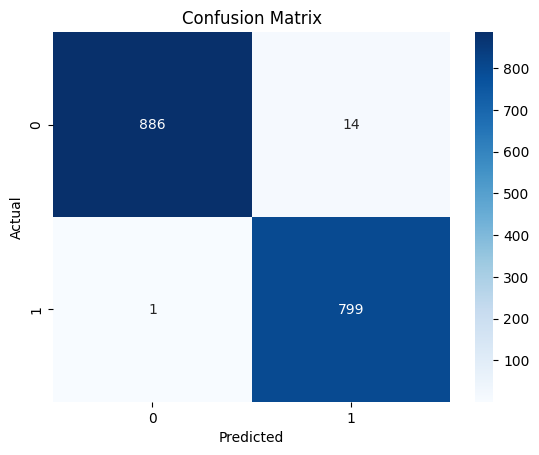

In [53]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()